# **UAV_IR_Surveillance**: Train example

Notebook muy sencillito para mostrar cómo hemos construido y entrenado a la red.

In [13]:
#####################################################
# Si se ejecuta desde colab, descomentar esta celda #
#####################################################

## Para descargar el proyecto e importar todas las dependencias
!git clone https://github.com/jesusBV20/UAV_IR_Surveillance.git
!mv UAV_IR_Surveillance/* . 
!rm -r UAV_IR_Surveillance

Cloning into 'UAV_IR_Surveillance'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 92 (delta 31), reused 69 (delta 15), pack-reused 0
Unpacking objects: 100% (92/92), 458.09 KiB | 3.66 MiB/s, done.


In [2]:
#####################################################
# Si se ejecuta desde colab, descomentar esta celda #
#####################################################

## ¿Qué GPU nos ha asignado google?
!nvidia-smi

## Visualizamos la lista de procesos corriendo en GPU
!sudo fuser -v /dev/nvidia*

## Matamos aquellos procesos zombie que nos están consumiendo memoria de GPU
#!sudo kill -9 147

Wed Apr  5 12:59:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#####################################################
# Si se ejecuta desde colab, descomentar esta celda #
#####################################################

## Para descargar y descomprimir los datos de forma automática --
from IPython.display import clear_output

!wget "https://lilablobssc.blob.core.windows.net/conservationdrones/v01/conservation_drones_train_real.zip"
!unzip conservation_drones_train_real.zip
clear_output()

!wget "https://lilablobssc.blob.core.windows.net/conservationdrones-testset/conservation_drones_test_real.zip"
!unzip conservation_drones_test_real.zip
clear_output()

print("Done!")

Done!


In [4]:
###################################################
# IMPORTANTE: Instalar la base de datos siguiendo #
# las instrucciones del README e indicar en estas #
# dos variables los direcctorios!!                #
TRAIN_DATA_PATH = "TrainReal"
TEST_DATA_PATH = "TestReal"
###################################################

## Librerías, clases y funciones externas

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from UAVIR_tools import BIRDSAIDataset, imgBoxes

WEIGHTS = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# Si se encuentra disponible, seleccionamos GPU como dispositivo para entrenar
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device: {}\n".format(device))

"""
Función que toma Faster-RCNN pre-entrenado y genera un nuevo modelo
aplicando un fine-tunning en el clasificador, adaptándolo al número
de clases, que debe de ser indicado en 'num_classes'. 
"""
def get_tunned_model(num_classes):
  # Cargamos el modelo pre-entrenado
  model = fasterrcnn_resnet50_fpn(weights=WEIGHTS)

  # Reemplazamos el clasificador de la red
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

"""
Función que nos retorna las transformaciones necesarias para codificar las
imágenes (en formato PIL), de tal forma que sean interpretables por la red.
"""
def get_transform():
  return WEIGHTS.transforms() # __call__(<PIL image>)

## Revisamos algunas imágenes del dataset

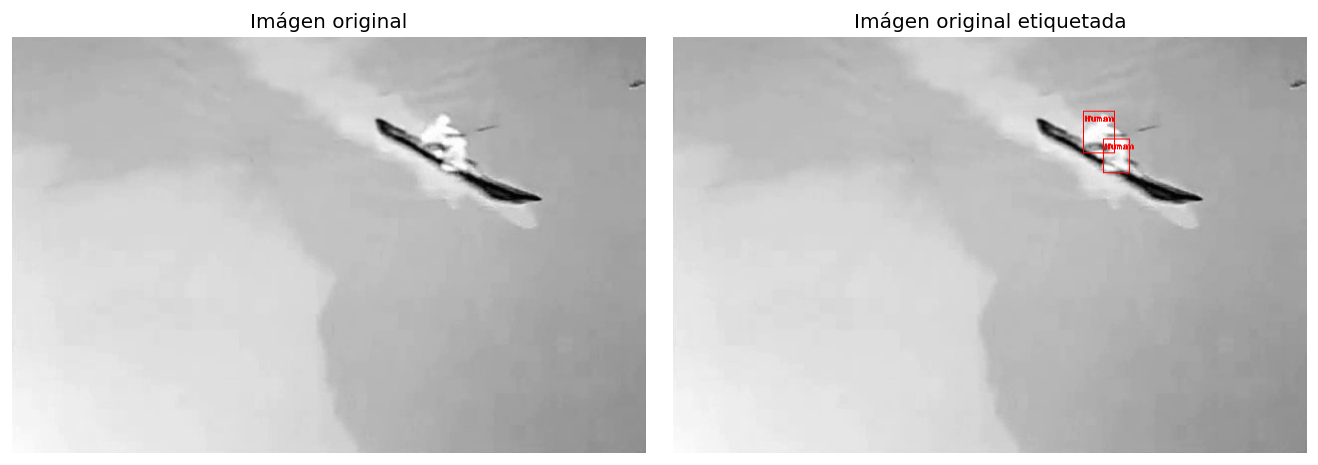

In [152]:
from torchvision import transforms as T

# Seleccionamos el vídeo y el frame
movie_id = 10
frame = 70

dataset = dataset = BIRDSAIDataset(TEST_DATA_PATH)
frame_init, frame_end, n_frames = dataset.getMovieBoxInfo(movie_id)

# Recogemos la img del dataset
img, target = dataset[frame_init + frame]

# Mostramos el resultado
FIGSIZE = [16, 9/2]
RES = 1920 # Full HD

transform_toImg = T.ToPILImage()
img_box_real = imgBoxes(img, target["boxes"], target["labels"])

fig = plt.figure(figsize=FIGSIZE, dpi=RES/FIGSIZE[0])
ax1, ax2 = fig.subplots(1,2)
plt.subplots_adjust(wspace=-0.2)

ax1.axis('off')
ax2.axis("off")

ax1.set_title("Imágen original")
ax2.set_title("Imágen original etiquetada")

ax1.imshow(img)
ax2.imshow(img_box_real)
plt.show()

## Comprobamos que podemos inferir sobre la red sin entrenar

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 83.8MB/s]


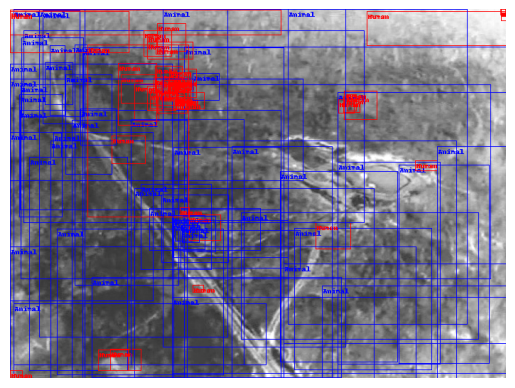

In [6]:
# Testeamos el tunned_model no entrenado
transforms = get_transform()

dataset = BIRDSAIDataset(TRAIN_DATA_PATH)
img, _ = dataset[0]
images = [transforms(d) for d in [img]]

model = get_tunned_model(3)
model_eval = model.eval()
outputs = model_eval(images)

# Mostramos el resultado
img_box = imgBoxes(img, outputs[0]["boxes"], outputs[0]["labels"])

fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')

ax.imshow(img_box)
plt.show()

## Entrenamos el modelo

In [22]:
import torch
import torchvision

from UAVIR_tools.detection.engine import train_one_epoch, evaluate
import UAVIR_tools.detection.utils as utils

# ------- MAIN --------- #
# Nuestro dataset tiene tres calses: 2 human, 1 animal, 0 background
num_classes = 3

# Definimos los dataset de train y test
dataset = BIRDSAIDataset(TRAIN_DATA_PATH, get_transform())
dataset_test = BIRDSAIDataset(TEST_DATA_PATH, get_transform())

# Generemos unos nuevos datasets basados en los originales, pero más pequeños
indices = torch.randperm(len(dataset)).tolist() # suffle de las imágenes
dataset = torch.utils.data.Subset(dataset, indices[0:1000])
dataset_test = torch.utils.data.Subset(dataset_test, indices[0:100])

# Definimos los DataLoaders de entrenamiento y evaluación
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=5, shuffle=True, num_workers=4,
  collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, num_workers=4,
  collate_fn=utils.collate_fn)

# Generamos el modelo utilizando la definida anteriormente
model = get_tunned_model(num_classes) 

# Guardamos el modelo en la RAM del dispositivo que estamos utilizando
model.to(device)

# Construimos un optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# y un learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

## Entrenamos para 'num_epochs' épocas ########################################
num_epochs = 5

for epoch in range(num_epochs):
  # Ejecutanmos una época del entrenamiento, imprimiendo cada 10 iteraciones
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # Actualizamos el learning rate
  lr_scheduler.step()

# ¡Guardamos el modelo entrenado!
torch.save(model.state_dict(), "model_AUVIR_test.pt")

Device: cuda



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0]  [  0/200]  eta: 0:08:08  lr: 0.000030  loss: 1.8194 (1.8194)  loss_classifier: 1.2769 (1.2769)  loss_box_reg: 0.2608 (0.2608)  loss_objectness: 0.2436 (0.2436)  loss_rpn_box_reg: 0.0381 (0.0381)  time: 2.4400  data: 0.8941  max mem: 7043
Epoch: [0]  [ 10/200]  eta: 0:05:07  lr: 0.000281  loss: 1.7236 (1.5698)  loss_classifier: 0.8905 (0.8779)  loss_box_reg: 0.1555 (0.1754)  loss_objectness: 0.2436 (0.4643)  loss_rpn_box_reg: 0.0403 (0.0522)  time: 1.6206  data: 0.0965  max mem: 7043
Epoch: [0]  [ 20/200]  eta: 0:04:51  lr: 0.000532  loss: 0.7658 (1.1196)  loss_classifier: 0.3806 (0.5834)  loss_box_reg: 0.1555 (0.1861)  loss_objectness: 0.1454 (0.2973)  loss_rpn_box_reg: 0.0521 (0.0528)  time: 1.5777  data: 0.0201  max mem: 7043
Epoch: [0]  [ 30/200]  eta: 0:04:32  lr: 0.000783  loss: 0.6192 (0.9772)  loss_classifier: 0.2839 (0.4966)  loss_box_reg: 0.2478 (0.2124)  loss_objectness: 0.0690 (0.2199)  loss_rpn_box_reg: 0.0476 (0.0483)  time: 1.5921  data: 0.0223  max mem: 7043


## Comprobamos resultados realizando alguna inferencia

In [183]:
OUTPUT_INFERENCE_PATH = "inference_output_imgs"

try:
  os.mkdir(OUTPUT_INFERENCE_PATH)
  print("¡Directorio '{}' creado!".format(OUTPUT_INFERENCE_PATH))
except:
  os.
  print("¡El directorio '{}' ya existe!".format(OUTPUT_INFERENCE_PATH))

¡El directorio 'inference_output_imgs' ya existe!


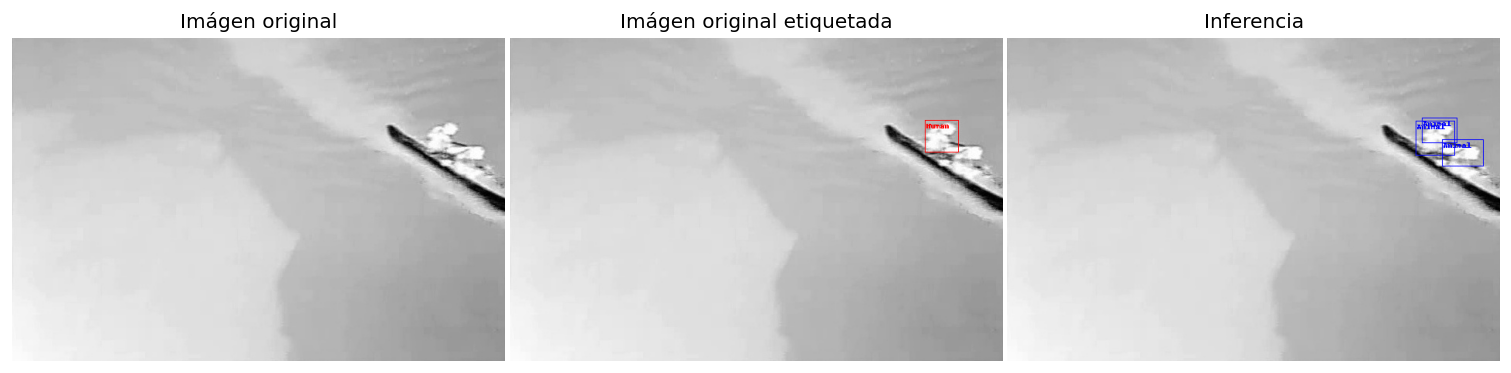

In [206]:
from torchvision import transforms as T

transforms = get_transform()

# Seleccionamos el vídeo y el frame
data_path = TEST_DATA_PATH
movie_id = 10
frame = 240

dataset = BIRDSAIDataset(data_path, transforms)
frame_init, frame_end, n_frames = dataset.getMovieBoxInfo(movie_id)

# Recogemos la img del dataset
img, target = dataset[frame_init + frame]
images = [img.to(device)]

# Cargamos el modelo entrenado
num_classes = 3
model = get_tunned_model(num_classes)

model.to(device)
model.load_state_dict(torch.load("model_AUVIR_test.pt"))

# Inferimos
model_eval = model.eval()
outputs = model_eval(images)

# Mostramos el resultado
FIGSIZE = [16, 9/2]
RES = 1920 # Full HD

transform_toImg = T.ToPILImage()
img = transform_toImg(img)

img_box_real = imgBoxes(img, target["boxes"], target["labels"])
img_box = imgBoxes(img, outputs[0]["boxes"], outputs[0]["labels"])

fig = plt.figure(figsize=FIGSIZE, dpi=RES/FIGSIZE[0])
ax1, ax2, ax3 = fig.subplots(1,3)
plt.subplots_adjust(wspace=0.01)

ax1.axis('off')
ax2.axis("off")
ax3.axis("off")

ax1.set_title("Imágen original")
ax2.set_title("Imágen original etiquetada")
ax3.set_title("Inferencia")

ax1.imshow(img)
ax2.imshow(img_box_real)
ax3.imshow(img_box)

plt.savefig(os.path.join(OUTPUT_INFERENCE_PATH, 
                         "{}-{}_{}.png".format(data_path,
                                               str(movie_id).zfill(4), 
                                               str(frame).zfill(5)) ),
            bbox_inches='tight', pad_inches = 0)
plt.show()

In [202]:
#######################################################################
# Comprimimos todas las salidas para poder descargarlas con facilidad #
#######################################################################

!zip -r inference_output_imgs.zip inference_output_imgs

updating: inference_output_imgs/ (stored 0%)
updating: inference_output_imgs/TestReal-0010_00240.png (deflated 5%)
updating: inference_output_imgs/TrainReal-0001_00040.png (deflated 4%)
updating: inference_output_imgs/TrainReal-0007_00045.png (deflated 4%)
updating: inference_output_imgs/TrainReal-0021_00070.png (deflated 5%)
updating: inference_output_imgs/TestReal-0010_00130.png (deflated 5%)
updating: inference_output_imgs/TrainReal-0004_00040.png (deflated 6%)
updating: inference_output_imgs/TestReal-0010_00100.png (deflated 4%)
  adding: inference_output_imgs/.ipynb_checkpoints/ (stored 0%)
